## Predicting the Price of VNQ
VNQ is a popular exchange-traded fund (ETF) sponsored by Vanguard that seeks to track the value of an index comprised of real estate trusts (REITs) and other stocks related to real property (e.g., builders, property managers). This notebook is designed to guide short-term investing in VNQ by seeking to predict the price of VNQ five minutes into the future based on the current and past prices of a basket of related stocks and index funds. The basket includes a portion of the ETF's underlying REITs and other stocks, interest rates and other asset classes (e.g., a gold ETF is included).

The investment thesis is that VNQ is unusually dependent on these related stocks, that the dependencies are extremely complex and that short-term pricing anomolies can be exploited.

To predict the VNQ price, a long short-term memory (LSTM) neural network is used, using sequences comprised of the VNQ stock price and approximately 20 other stock prices in five-minute intervals over five periods. Thus the inputs to the model can be described as a series of 5 x 20 matrixes that seek to predict the next price (five minutes hence) of VNQ.

The data was sourced from Yahoo Finance via its free API, which limits 5-minute backward-looking data to 60 days. After the initial 60 days were drawn, the data was continually updated on a daily basis. The model was re-trained on the most up-to-date dataset each day, with parameters reassessed on a weekly basis.

Each day, an economic ROI assessment was also conducted, to estimate how well the model performed (hypothetically) each day of the model were followed strictly.

**Daily Sequence of Steps**

- Load imports, functions and key variables (STEPs 1, 2)  
- Load master data (STEP 3)  
- Load saved model trained on most up-to-date data (STEP 4)  
- Make daily predictions (STEP 4 cont.)  
- Assess daily performance (STEP A)  
- Append daily data to master dataset  and save (STEP B)  
- Re-run the model using the expanded dataset (STEP C)  
- Tweak model approximately once a week (STEP AA)  

## (1) Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)
data_dir = 'C:/Users/Robert McKee/MOREHERE'
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pickle

from sklearn.preprocessing import MinMaxScaler

import yfinance as yf

from datetime import datetime, timedelta, time, date
import time 
import schedule 
from threading import Timer


from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers, regularizers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras.models import load_model
import h5py
import keras.losses
import tensorflow as tf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

Using TensorFlow backend.


## (2) Utility Functions and Variables

In [2]:
# https://www.portfoliovisualizer.com/asset-class-correlations
tickers = [
    'VNQ', 'AMT', 'PLD', 'CCI', 'SPG', 'WELL', 'PSA', 'EQR', 'AVB', 'SBAC',
    'DLR', 'O', 'WY', 'VTR', 'BXP', 'ARE', 'CBRE', 'BND', 'IEF', 'IWM', 'SPY',
    'DBC', 'GLD', 'VWO', 'VEU', 'TIP', 'SHY'
]  # VIX not available, 'ESS',EQIX

cols_to_use = [
    'VNQ_Close', 'AMT_Close', 'PLD_Close', 'CCI_Close', 'SPG_Close',
    'WELL_Close', 'PSA_Close', 'EQR_Close', 'AVB_Close', 'SBAC_Close',
    'DLR_Close', 'O_Close', 'WY_Close', 'VTR_Close', 'BXP_Close', 'ARE_Close',
    'CBRE_Close', 'BND_Close', 'IEF_Close', 'IWM_Close', 'SPY_Close',
    'DBC_Close', 'GLD_Close', 'VWO_Close', 'VEU_Close', 'TIP_Close',
    'SHY_Close', 'VNQ_Open'
]

feature_generation_columns = [
    'VNQ_Close', 'AMT_Close', 'PLD_Close', 'CCI_Close', 'SPG_Close',
    'WELL_Close', 'PSA_Close', 'EQR_Close', 'AVB_Close', 'SBAC_Close',
    'DLR_Close', 'O_Close', 'WY_Close', 'VTR_Close', 'BXP_Close', 'ARE_Close',
    'CBRE_Close', 'BND_Close', 'IEF_Close', 'IWM_Close', 'SPY_Close',
    'DBC_Close', 'GLD_Close', 'VWO_Close', 'VEU_Close', 'TIP_Close',
    'SHY_Close'
]

STEPS = 5

y_idx = 0

drop_val = 0.2

beg_linspace = 1
end_linspace = 1.4

In [3]:
def prep_df(df, cols):
    df = df[cols]
    df.index = pd.to_datetime(df.index.strftime('%Y-%m-%d %H:%M:%S')) ## NEW 
    df = df.loc[(df.index.minute % 5 == 0) & (df.index.second == 0)]
    #     df.drop(df.tail(1).index,inplace=True)
    df = df.fillna(method='ffill')  # Need to incorporate
    df['First_five_intervals'] = np.where(
        (df.index.hour == 9) & ((df.index.minute >= 30) &
                                (df.index.minute <= 40)), 1, 0)
    df.dropna(inplace=True)
    return df


def build_model():
    '''Builds a keras/neural network model'''
    # Initialising the RNN
    model = Sequential()
    # Adding the first LSTM layer and some Dropout regularisation
    model.add(
        LSTM(units=50,
             kernel_regularizer=regularizers.l2(0.001),
             return_sequences=True,
             input_shape=(X_train.shape[1], X_train.shape[2]))
    )  # input shape=time steps, predictors; last number was 1
    model.add(Dropout(drop_val))

    # Adding a second LSTM layer and some Dropout regularisation
    model.add(
        LSTM(units=50,
             kernel_regularizer=regularizers.l2(0.001),
             return_sequences=True))
    model.add(Dropout(drop_val))

    # Adding a third LSTM layer and some Dropout regularisation
    model.add(
        LSTM(units=50,
             kernel_regularizer=regularizers.l2(0.001),
             return_sequences=True))
    model.add(Dropout(drop_val))

    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=50, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(drop_val))

    # Adding the output layer
    model.add(Dense(units=1))  # predicting a single value (VNQ adj close)
    # Compiling the RNN
    model.compile(optimizer='AdaDelta',
                  loss='mean_squared_error', #'mean_squared_error'
                  metrics=['mae'])  #loss = 'mean_absolute_error'; no quotes on
    # cust loss == eg, sign_penalty

    return model


# Create loss function
# def sign_penalty(y_true, y_pred):
#     penalty = 1.25
#     loss = tf.where(tf.less(y_true * y_pred, 0),
#                      penalty * tf.square(y_true - y_pred),
#                      tf.square(y_true - y_pred))

#     return tf.reduce_mean(loss, axis=-1)


def sign_penalty(y_true, y_pred):
    '''Penalizes n times for prediction that is higher than actual. Returns mse with penalty 
    '''
    diff = y_pred - y_true  # Diff b/w pred and true -- negative if over-confident
    #     diff = y_true - y_pred

    greater = K.greater(diff, 0)
    greater = K.cast(greater, K.floatx())  #0 for lower, 1 for greater
    greater = greater + 1  #1 for lower, n+1 for greater

    #use some kind of loss here, such as mse or mae, or pick one from keras
    #using mse:
    return K.mean(greater * K.square(diff))


def fetch_data_today(tickers, period, interval):
    d = {}
    for ticker in tickers:
        print("Fetching: ", ticker)
        temp_obj = yf.Ticker(ticker)
        temp_hist = temp_obj.history(period=period, interval=interval)
        temp_hist.columns = [
            ticker + '_' + str(col) for col in temp_hist.columns
        ]
        d[ticker] = temp_hist
        df_temp = pd.concat(d.values(), axis=1)
    return df_temp


keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras


def prep_time(now):
    h = str(now.hour)
    if len(h) == 1:
        h = str(0) + h
    m = str(now.minute)
    if len(m) == 1:
        m = str(0) + m
    s = str(now.second)
    if len(s) == 1:
        s = str(0) + s
    return h, m, s

def prnttime():
    print(datetime.now().strftime('%H:%M:%S'))
    
def get_earnings_snapshot(earnings_df):

    abs_change_mean=earnings_df['Change'].abs().mean()
    abs_diff_pred_v_actual_mean=earnings_df['Difference'].abs().mean()
    actual_change_std=earnings_df['Change'].std()
    pred_match_pct=earnings_df['Match'].sum()/earnings_df.shape[0]
    over_confident_preds=len(earnings_df[earnings_df['Difference'] > 0])/earnings_df.shape[0]
    net_earnings=earnings_df['Cum_earnings'].iloc[-1]
    net_price_change= earnings_df['Actual'].iloc[-2] - earnings_df['Actual'].iloc[0]  
    d={"abs_change_mean": abs_change_mean, "abs_diff_pred_v_actual_mean": abs_diff_pred_v_actual_mean, 
            "actual_change_std": actual_change_std, "pred_match_pct": pred_match_pct, 'over_confident_preds': over_confident_preds,
                    'net_price_change': net_price_change, "net_earnings": net_earnings}
    earnings_df=pd.DataFrame(d, index=["Results"])
    return earnings_df
         
def calculate_earnings(row):
    delta=0.03
    if (row['Pred_dir'] == 'Up') & ((row['Predicted'] - row['Prior']) >= delta):
        return row['Change']
    else: 
        return 0 

def get_trading_results(df, predictions, steps=STEPS):

    '''
    Takes predictions from a stock forecasting model and calculates various metrics from using those predictions,
    including daily earnings if the model was implemented exactly

    df: the dataframe with features used for predictions and the target variable (actual stock price)	
    predictions: the predicted stock price 			
    returns: dataframe with trading results
    '''
    new_df=pd.DataFrame(index=df.index) # Instantiate a new dataframe, with same index as prediction dataset
    new_df=new_df[steps:] # Trim the first n (steps) as they do not have an associated prediction 
    new_df['Predicted']=predictions    
    new_df['Predicted']=new_df['Predicted'].shift(1) #Shifts prediction to row with actual results 
    new_df['Prior']=df['VNQ_Open'].values[steps:]
    new_df['Actual']=df['VNQ_Close'].values[steps:]
    new_df['Difference']=round(new_df['Predicted']-new_df['Actual'],2) # Pred - actual 
    new_df['Pred_dir']=np.where(new_df['Predicted'] >= new_df['Prior'], 'Up', 'Down')
    new_df['Actual_dir']=np.where(new_df['Actual'] >= new_df['Prior'], 'Up', 'Down')
    new_df['Change']=new_df['Actual']-new_df['Prior'] # Actual close vs prior actual close 
    new_df['Match']=np.where(new_df['Pred_dir']==new_df['Actual_dir'], True, False)
    new_df['Earnings']=new_df.apply(calculate_earnings, axis=1)
    new_df['Cum_earnings']=new_df['Earnings'].cumsum()
    new_df['First_five_intervals']=np.where( (new_df.index.hour == 9 ) & 
                   ( (new_df.index.minute >= 30) & (new_df.index.minute <= 50) ), 1, 0 )
    new_df.dropna(axis=0, inplace=True) # Deletes first row, as it has no associated prediction 
    return new_df

def fetch_data(tickers, start, end, interval):
    d = {}
    for ticker in tickers:
        print("Fetching: ", ticker)
        temp_obj=yf.Ticker(ticker)
        temp_hist=temp_obj.history(start=start, end=end, interval=interval)  
        temp_hist.columns = [ticker + '_' + str(col) for col in temp_hist.columns]
        d[ticker]=temp_hist
        df_temp=pd.concat(d.values(), axis=1)
    return df_temp 


def get_rolling_features(df, base_columns, join_index=0):
    '''
    Creates rolling mean features based on stock prices over various time intervals.
    
    df: the dataframe to which new rolling features will be added 
    base_columns: columns to be used in feature generation 
    join_index: the point in the dataframe (row index) where new features should be added; defaults to 0 to apply to 
        entire dataframe 
    returns: dataframe with new rolling features 
    '''
    windows = [20, 234, 1_170] # last 20 intervals, 3 days and 15 days
    for i in range(len(base_columns)):
        for j in range(len(windows)):
            col_name = base_columns[i] + '_Rolling_Mean_' + str(
                windows[j])
            if join_index == 0: 
                 df[col_name] = df[base_columns[i]].rolling(
                    window=windows[j], min_periods=1).mean()            
            else:             
                df[col_name][-join_index:] = df[base_columns[i]].rolling(
                    window=windows[j], min_periods=1).mean()[-join_index:]
    return df


## (3) Load Latest Data  

After an initial loading of historical data (see Appendix), data is updated on a daily basis (or other interval) and saved.  

In [4]:
# Load data
df_master_augmented=pd.read_pickle('df_master_05_08_2020.pkl')
print(df_master_augmented.shape)
# print("NaNs :", df_master_augmented.isna().sum().sum())

# Load latest scaler
scalerfile = 'scaler_aug.sav'
sc = pickle.load(open(scalerfile, 'rb'))


(10302, 110)


## Neural Network -- Model Tuning 

Use this section to occasionally re-tune the model.  On a more regular basis (e.g., daily), the model can be re-trained on newly available data (keeping previous hyperparameters).  Go to next section for the re-training process.   

http://localhost:8888/notebooks/RNN_LSTM_Google_Stock_Price/RNN_LSTM_Stock_Prediction.ipynb  
https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

### Final Data Prep

#### Training Data 

In [ ]:
# start_pt= df_master.shape[0]-(78*6)  # 78 intervals/day (5m)
start_pt= 0
no_days=3
# no_days=8
cutoff=int(df_master_augmented.shape[0] - (78 * no_days)) # NEW
df_train=df_master_augmented[start_pt:cutoff].copy() # NEW
df_test=df_master_augmented[cutoff:].copy() # NEW

In [ ]:
print(df_train.shape)
print(df_test.shape)

In [ ]:
# Feature Scaling Normalization
sc = MinMaxScaler(feature_range = (0, 1))

# training_set_scaled = sc.fit_transform(df_train)  # last column remains 
training_set_scaled = sc.fit_transform(df_train.iloc[:, :-1])  # .iloc[:, :-1] removes last column # DELETE w/o VNQ 

# test_set_scaled=sc.transform(df_test) # DELETED

# Save scaler
scalerfile = 'scaler.sav'
pickle.dump(sc, open(scalerfile, 'wb'))

# # Load it back:
# scalerfile = 'scaler.sav'
# sc = pickle.load(open(scalerfile, 'rb'))

In [ ]:
training_set_scaled

In [ ]:
# Creating a data structure with n timesteps and 1 output
X_train = []
y_train = []
for i in range(STEPS, df_train.shape[0]):  # From n steps to 1110
    X_train.append(training_set_scaled[i-STEPS:i, :]) 
    y_train.append(training_set_scaled[i, y_idx]) # Sets y as the next value after the n steps; eg, 5 steps predicts 6th  
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

#### Test Data

In [ ]:
y_true= df_test['VNQ_Close'].values # Getting the unscaled actual stock prices
dataset_total_df = pd.concat((df_train, df_test), axis = 0)
##
temp_idx=dataset_total_df.shape[0]-df_test.shape[0]-STEPS # Yields today's intervals plus # STEPS prior (e.g., 5)
dataset_total_df=dataset_total_df[temp_idx:].copy()
# inputs=dataset_total_df.values # Leaves last column in 
inputs=dataset_total_df.values[:, :-1] # Removes the last column - VNQ Open # DELETE 
##
# inputs = dataset_total[len(dataset_total) - len(df_test) - STEPS:].values  # Pulls in last n observations (steps) into test set 
inputs.shape

In [ ]:
# sc2 = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.transform(inputs)

X_test = []
y_test=[]
for i in range(STEPS, len(inputs)):
    X_test.append(test_set_scaled[i-STEPS:i, :])
    y_test.append(test_set_scaled[i, y_idx])
X_test, y_test= np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

### Run Model

In [ ]:
beg_linspace=1
end_linspace=1.2
sample_weight = np.linspace(beg_linspace, end_linspace, num=X_train.shape[0])
# sample_weight = np.logspace(0,1,num=X_train.shape[0])

In [ ]:
# Use for optimizing the neural network
callbacks_list = [
    EarlyStopping(
        patience=10, verbose=True, monitor='val_loss', restore_best_weights=True), # 'val_loss'
    ModelCheckpoint('weights_02_26a.{epoch:02d}_{val_loss:.4f}.hdf5', verbose=True, save_best_only=True)
]

In [ ]:
## Train model
seed = 7
BATCH_SIZE = 64  # 32 is the default
EPOCHS = 100
np.random.seed(seed)

model = build_model()
history = model.fit(
    X_train,  
    y_train,
    epochs=EPOCHS,
    callbacks=callbacks_list,
#     shuffle=False,
    batch_size=BATCH_SIZE,
    sample_weight=sample_weight,
    validation_data=(X_test, y_test))

In [ ]:
EPOCHS=44
model=build_model()
model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, sample_weight=sample_weight) #, sample_weight=sample_weight

In [ ]:
import gc; gc.collect()

In [ ]:
# Retrieve train MAE (mean absolute error) and test MAE
mse= history.history['loss']
val_mse = history.history['val_loss']
pd.options.display.max_rows = 999
# val_mse=[round(elem, 4) for elem in val_mse]
# mse=[round(elem, 4) for elem in mse]
mse_df=pd.DataFrame(list(zip(mse, val_mse)), columns=['MSE', 'VAL_MSE'])
mse_df.shift()[1:] # Sets the index start to 1 

In [ ]:
# Plot train MAE and
mse_df.plot()
plt.show()

### Prediction Earnings/Losses

In [ ]:
# model = load_model('weights_01_24a.50-0.0035.hdf5')
# model=build_model()
# model.fit(X_train, y_train, epochs = 50, batch_size = 64) #, sample_weight=sample_weight

In [ ]:
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
# y_idx=0
predicted_VNQ_price = model.predict(X_test)
predicted_VNQ_price=predicted_VNQ_price.flatten()
predicted_VNQ_price = (predicted_VNQ_price * sc.data_range_[y_idx]) + sc.data_min_[y_idx] 
predicted_VNQ_price

In [ ]:
# Visualising the results
plt.plot(y_true, color = 'red', label = 'Real VNQ Price')
plt.plot(predicted_VNQ_price, color = 'blue', label = 'Predicted VNQ Price')
plt.title('VNQ Price Prediction')
plt.xlabel('Intervals')
plt.ylabel('VNQ Price')
plt.legend()
plt.show()

In [ ]:
temp_idx2=dataset_total_df.shape[0] # NEW 
dataset_total_df['VNQ_Open']=df_master_augmented['VNQ_Open'][-temp_idx2 :] # NEW - ADDED to re-append VNQ Open 
results_df=get_trading_results(dataset_total_df, predicted_VNQ_price)
pd.options.display.float_format = '{:,.2f}'.format
results_df

In [ ]:
net_earnings_df=get_earnings_snapshot(results_df)
net_earnings_df.T

1/27, 40 epochs 
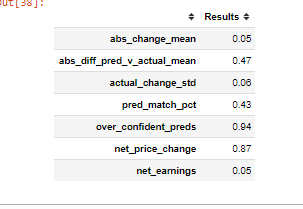 
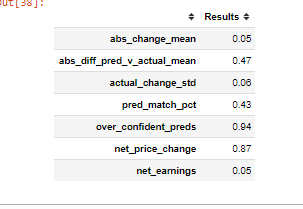

5 step model:  
_ 30x predicted up and was right  
_ 18x predicted up and was wrong    
_ Assuming 1 share bought each time...    
_ Earned $6.93 on 48 trades of one share/per, over 141 trading days    
_ If traded 500 shares, profit of $3465, with approx $45000 of capital at play -- about 7.7% return
_ NEED TO LOOK AT DIFF TRANCHES -- EG DOWN MARKET 

## (4) Real Time Prediction

In [5]:
model = load_model('my_model_05_08_2020.h5')
df_train=df_master_augmented.copy()  # NEW
df_train.shape

(10302, 110)


Automatic Loop 

In [9]:
# Get current time 
prnttime()    

09:55:15


In [ ]:
starttime=time.time()

while True:
    print("Fetching started...")

    data_today = fetch_data_today(tickers, period="1d", interval='5m')
    df_eod_today = prep_df(data_today, cols_to_use)
    df_eod_today = df_eod_today.loc[(df_eod_today.index.minute % 5 == 0)
                            & (df_eod_today.index.second == 0)]

    ##

    now = datetime.now().replace(microsecond=0)
    last_idx = df_eod_today.index.to_pydatetime()
    last_idx = last_idx[-1]
    last_idx = last_idx.replace(tzinfo=None)
    if (now - last_idx) < timedelta(minutes=5):
        #         print("trim")
        df_eod_today.drop(df_eod_today.tail(1).index, inplace=True)
    else:
        print("dont trim")
    y_today_test = df_eod_today['VNQ_Close'].values
    dataset_total = pd.concat((df_train, df_eod_today), axis=0, sort=False) # sort=False
    dataset_total = dataset_total[df_master_augmented.columns] # ensures column alignment 

    ##
    concat_point = df_eod_today.shape[0]
    print("STILL WORKING ")
    dataset_total=get_rolling_features(dataset_total, feature_generation_columns, join_index=concat_point) ## TROUBLESHOOT?????????????????????????????????
    print("STILL WORKING 2")

    ##
    inputs = dataset_total[len(dataset_total) - len(df_eod_today) - STEPS:].values  # Pulls in last n observations (steps) into test set
    #     sc2 = MinMaxScaler(feature_range = (0, 1))
#     inputs = sc.fit_transform(inputs)
    inputs = sc.fit_transform(inputs[:, :-1]) # Eliminates last column -- VNQ Open # DELETE    ????????????????????????????????????????
    X_test_today = []
    for i in range(STEPS, len(inputs)):
        X_test_today.append(inputs[i-STEPS:i, :])
    X_test_today = np.array(X_test_today)
    pred_VNQ_today = model.predict(X_test_today)
    pred_VNQ_today=pred_VNQ_today.flatten()
    pred_VNQ_today = (pred_VNQ_today * sc.data_range_[y_idx]) + sc.data_min_[y_idx]
    current= round(df_eod_today.VNQ_Close[-1], 2)
    predicted=round(pred_VNQ_today[-1],2)
    difference=round(predicted - current,2)

    print("CURRENT:    ",   current)
    print("PREDICTED:  ", predicted )
    print("----" * 30)
    print("DIFFERENCE:  ", difference)
    if difference >= 0.04:
          print("**BUY**")
    else:
          print("**DO NOT BUY**")

    prnttime()
    
    if (now.hour >= 16) & (now.minute >= 5):
        print ('POST-4PM BREAK')
        break

    time.sleep(300.0 - ((time.time() - starttime) % 300.0))

Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CURRENT:     73.6
PREDICTED:   74.67
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   1.07
**BUY**
09:55:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:     73.7
PREDICTED:   74.38
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.68
**BUY**
10:00:23


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     73.67
PREDICTED:   74.39
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.72
**BUY**
10:05:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     73.85
PREDICTED:   74.31
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.46
**BUY**
10:10:25
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:     73.79
PREDICTED:   74.28
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.49
**BUY**
10:15:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     73.74
PREDICTED:   74.27
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.53
**BUY**
10:20:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     73.97
PREDICTED:   74.26
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.29
**BUY**
10:25:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.1
PREDICTED:   74.23
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.13
**BUY**
10:30:24
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.32
PREDICTED:   74.23
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.09
**DO NOT BUY**
10:35:24
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:     74.1
PREDICTED:   74.21
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.11
**BUY**
10:40:23


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CURRENT:     74.04
PREDICTED:   74.23
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.19
**BUY**
10:45:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CURRENT:     74.19
PREDICTED:   74.29
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.1
**BUY**
10:50:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.12
PREDICTED:   74.31
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.19
**BUY**
10:55:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     74.11
PREDICTED:   74.34
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.23
**BUY**
11:00:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.27
PREDICTED:   74.3
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.03
**DO NOT BUY**
11:05:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.39
PREDICTED:   74.3
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.09
**DO NOT BUY**
11:10:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     74.19
PREDICTED:   74.29
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.1
**BUY**
11:15:23


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     74.29
PREDICTED:   74.26
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.03
**DO NOT BUY**
11:20:23


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:     74.27
PREDICTED:   74.25
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.02
**DO NOT BUY**
11:25:23


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.46
PREDICTED:   74.25
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.21
**DO NOT BUY**
11:30:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.53
PREDICTED:   74.25
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.28
**DO NOT BUY**
11:35:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2

c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CURRENT:     74.6
PREDICTED:   74.27
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.33
**DO NOT BUY**
11:40:43
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CURRENT:     74.47
PREDICTED:   74.32
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.15
**DO NOT BUY**
11:45:43
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:     74.57
PREDICTED:   74.37
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.2
**DO NOT BUY**
11:50:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:     74.5
PREDICTED:   74.44
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.06
**DO NOT BUY**
11:55:23


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     74.47
PREDICTED:   74.48
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.01
**DO NOT BUY**
12:00:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     74.47
PREDICTED:   74.51
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.04
**BUY**
12:05:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.45
PREDICTED:   74.52
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.07
**BUY**
12:10:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CURRENT:     74.4
PREDICTED:   74.55
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   0.15
**BUY**
12:15:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:    

c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 74.59
PREDICTED:   74.55
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.04
**DO NOT BUY**
12:20:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     74.79
PREDICTED:   74.55
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.24
**DO NOT BUY**
12:25:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.9
PREDICTED:   74.54
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.36
**DO NOT BUY**
12:30:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     74.92
PREDICTED:   74.54
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.38
**DO NOT BUY**
12:35:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     75.08
PREDICTED:   74.57
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.51
**DO NOT BUY**

c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



12:40:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:     74.89
PREDICTED:   74.62
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.27
**DO NOT BUY**
12:45:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     74.82
PREDICTED:   74.68
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.14
**DO NOT BUY**
12:50:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.87
PREDICTED:   74.71
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.16
**DO NOT BUY**
12:55:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.86
PREDICTED:   74.73
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.13
**DO NOT BUY**
13:00:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:     74.86
PREDICTED:   74.74
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.12
**DO NOT BUY**
13:05:23


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.97
PREDICTED:   74.73
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.24
**DO NOT BUY**
13:10:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:    

c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 74.98
PREDICTED:   74.72
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.26
**DO NOT BUY**
13:15:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 
STILL WORKING 2
CURRENT:     74.86
PREDICTED:   74.74
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.12
**DO NOT BUY**
13:20:23


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.85
PREDICTED:   74.74
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.11
**DO NOT BUY**
13:25:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.89
PREDICTED:   74.75
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.14
**DO NOT BUY**
13:30:25
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.93
PREDICTED:   74.76
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.17
**DO NOT BUY**
13:35:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 
STILL WORKING 2
CURRENT:     75.01
PREDICTED:   74.76
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.25
**DO NOT BUY**
13:40:22


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.87
PREDICTED:   74.75
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.12
**DO NOT BUY**
13:45:24
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.89
PREDICTED:   74.75
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.14
**DO NOT BUY**
13:50:23
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.87
PREDICTED:   74.77
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.1
**DO NOT BUY**
13:55:22
Fetching started...
Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
dont trim
STILL WORKING 


c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


STILL WORKING 2
CURRENT:     74.8
PREDICTED:   74.77
------------------------------------------------------------------------------------------------------------------------
DIFFERENCE:   -0.03
**DO NOT BUY**
14:00:22


## (A) Daily Results Analysis

In [41]:
save_date = datetime.strftime(datetime.now(), '_%m_%d_%Y')
# save_date = '_05_05_2020'  # Only when overriding date 
save_date

'_05_08_2020'

In [42]:
data_today = fetch_data_today(tickers, period="1d", interval='5m')
# data_today = fetch_data(tickers, start="2020-03-30", end="2020-04-01", interval='5m') # Use if day(s) are missed; must load fetch_data (not fetch_data_today function)
df_eod_today=prep_df(data_today, cols_to_use)
print(df_eod_today.shape)

Fetching:  VNQ
Fetching:  AMT
Fetching:  PLD
Fetching:  CCI
Fetching:  SPG
Fetching:  WELL
Fetching:  PSA
Fetching:  EQR
Fetching:  AVB
Fetching:  SBAC
Fetching:  DLR
Fetching:  O
Fetching:  WY
Fetching:  VTR
Fetching:  BXP
Fetching:  ARE
Fetching:  CBRE
Fetching:  BND
Fetching:  IEF
Fetching:  IWM
Fetching:  SPY
Fetching:  DBC
Fetching:  GLD
Fetching:  VWO
Fetching:  VEU
Fetching:  TIP
Fetching:  SHY
(78, 29)


In [43]:
# Clean tail (always)
df_eod_today=df_eod_today.loc[(df_eod_today.index.minute % 5 == 0) & (df_eod_today.index.second == 0)]
df_eod_today.tail(5)

,VNQ_Close,AMT_Close,PLD_Close,CCI_Close,SPG_Close,WELL_Close,PSA_Close,EQR_Close,AVB_Close,SBAC_Close,DLR_Close,O_Close,WY_Close,VTR_Close,BXP_Close,ARE_Close,CBRE_Close,BND_Close,IEF_Close,IWM_Close,SPY_Close,DBC_Close,GLD_Close,VWO_Close,VEU_Close,TIP_Close,SHY_Close,VNQ_Open,First_five_intervals
2020-05-08 15:35:00,74.96,238.01,89.82,157.30,58.01,44.53,190.27,64.30,163.77,291.01,145.00,54.67,19.82,29.95,87.19,152.06,41.67,86.91,121.47,132.30,292.30,11.23,160.39,36.48,43.92,121.29,86.65,74.93,0
2020-05-08 15:40:00,75.00,238.12,89.87,157.38,58.01,44.63,190.40,64.37,164.11,290.74,144.95,54.70,19.76,29.90,87.20,151.93,41.68,86.91,121.49,132.34,292.48,11.23,160.36,36.50,43.95,121.29,86.65,74.96,0
2020-05-08 15:45:00,74.99,238.00,89.90,157.50,57.99,44.60,190.66,64.32,163.89,291.07,145.01,54.66,19.80,29.75,87.11,151.89,41.71,86.92,121.52,132.37,292.48,11.23,160.38,36.50,43.95,121.32,86.65,75.00,0
2020-05-08 15:50:00,75.07,238.19,90.02,157.70,58.02,44.64,190.47,64.31,164.16,291.73,145.20,54.79,19.84,29.97,87.27,152.01,41.74,86.93,121.53,132.30,292.68,11.23,160.47,36.53,43.97,121.34,86.66,74.98,0
2020-05-08 15:55:00,75.01,238.14,89.93,157.70,57.93,44.55,190.17,64.22,163.84,291.87,145.21,54.85,19.84,30.07,86.93,151.58,41.59,86.95,121.53,132.34,292.46,11.23,160.46,36.50,43.98,121.40,86.66,75.08,0


In [44]:
now=datetime.now().replace(microsecond=0)
last_idx=df_eod_today.index.to_pydatetime()
last_idx=last_idx[-1]
last_idx = last_idx.replace(tzinfo=None)
if (now - last_idx) < timedelta(minutes=5) :
    print("trim") 
    df_eod_today.drop(df_eod_today.tail(1).index,inplace=True)
else: 
    print("dont trim")
df_eod_today.tail(3) 

dont trim


,VNQ_Close,AMT_Close,PLD_Close,CCI_Close,SPG_Close,WELL_Close,PSA_Close,EQR_Close,AVB_Close,SBAC_Close,DLR_Close,O_Close,WY_Close,VTR_Close,BXP_Close,ARE_Close,CBRE_Close,BND_Close,IEF_Close,IWM_Close,SPY_Close,DBC_Close,GLD_Close,VWO_Close,VEU_Close,TIP_Close,SHY_Close,VNQ_Open,First_five_intervals
2020-05-08 15:45:00,74.99,238.00,89.90,157.5,57.99,44.60,190.66,64.32,163.89,291.07,145.01,54.66,19.80,29.75,87.11,151.89,41.71,86.92,121.52,132.37,292.48,11.23,160.38,36.50,43.95,121.32,86.65,75.00,0
2020-05-08 15:50:00,75.07,238.19,90.02,157.7,58.02,44.64,190.47,64.31,164.16,291.73,145.20,54.79,19.84,29.97,87.27,152.01,41.74,86.93,121.53,132.30,292.68,11.23,160.47,36.53,43.97,121.34,86.66,74.98,0
2020-05-08 15:55:00,75.01,238.14,89.93,157.7,57.93,44.55,190.17,64.22,163.84,291.87,145.21,54.85,19.84,30.07,86.93,151.58,41.59,86.95,121.53,132.34,292.46,11.23,160.46,36.50,43.98,121.40,86.66,75.08,0


In [45]:
df_total= pd.concat((df_train,df_eod_today), axis = 0, sort=False)

In [46]:
df_total.tail(85).T

,2020-05-07 15:25:00,2020-05-07 15:30:00,2020-05-07 15:35:00,2020-05-07 15:40:00,2020-05-07 15:45:00,2020-05-07 15:50:00,2020-05-07 15:55:00,2020-05-08 09:30:00,2020-05-08 09:35:00,2020-05-08 09:40:00,2020-05-08 09:45:00,2020-05-08 09:50:00,2020-05-08 09:55:00,2020-05-08 10:00:00,2020-05-08 10:05:00,2020-05-08 10:10:00,2020-05-08 10:15:00,2020-05-08 10:20:00,2020-05-08 10:25:00,2020-05-08 10:30:00,2020-05-08 10:35:00,2020-05-08 10:40:00,2020-05-08 10:45:00,2020-05-08 10:50:00,2020-05-08 10:55:00,2020-05-08 11:00:00,2020-05-08 11:05:00,2020-05-08 11:10:00,2020-05-08 11:15:00,2020-05-08 11:20:00,2020-05-08 11:25:00,2020-05-08 11:30:00,2020-05-08 11:35:00,2020-05-08 11:40:00,2020-05-08 11:45:00,2020-05-08 11:50:00,2020-05-08 11:55:00,2020-05-08 12:00:00,2020-05-08 12:05:00,2020-05-08 12:10:00,2020-05-08 12:15:00,2020-05-08 12:20:00,2020-05-08 12:25:00,2020-05-08 12:30:00,2020-05-08 12:35:00,2020-05-08 12:40:00,2020-05-08 12:45:00,2020-05-08 12:50:00,2020-05-08 12:55:00,2020-05-08 13:00:00,2020-05-08 13:05:00,2020-05-08 13:10:00,2020-05-08 13:15:00,2020-05-08 13:20:00,2020-05-08 13:25:00,2020-05-08 13:30:00,2020-05-08 13:35:00,2020-05-08 13:40:00,2020-05-08 13:45:00,2020-05-08 13:50:00,2020-05-08 13:55:00,2020-05-08 14:00:00,2020-05-08 14:05:00,2020-05-08 14:10:00,2020-05-08 14:15:00,2020-05-08 14:20:00,2020-05-08 14:25:00,2020-05-08 14:30:00,2020-05-08 14:35:00,2020-05-08 14:40:00,2020-05-08 14:45:00,2020-05-08 14:50:00,2020-05-08 14:55:00,2020-05-08 15:00:00,2020-05-08 15:05:00,2020-05-08 15:10:00,2020-05-08 15:15:00,2020-05-08 15:20:00,2020-05-08 15:25:00,2020-05-08 15:30:00,2020-05-08 15:35:00,2020-05-08 15:40:00,2020-05-08 15:45:00,2020-05-08 15:50:00,2020-05-08 15:55:00
VNQ_Close,73.210000,73.230000,73.240000,73.290000,73.320000,73.330000,73.250000,74.57,74.47,74.58,74.88,74.88,74.98,74.87,74.91,75.10,75.00,74.80,74.61,74.55,74.62,74.22,74.46,74.47,74.40,74.40,74.59,74.58,74.75,74.83,74.70,74.63,74.74,74.75,74.69,74.64,74.60,74.59,74.65,74.62,74.53,74.50,74.49,74.45,74.49,74.51,74.46,74.55,74.43,74.43,74.30,74.42,74.47,74.49,74.46,74.49,74.55,74.49,74.49,74.52,74.57,74.45,74.57,74.71,74.71,74.78,74.81,74.76,74.72,74.76,74.72,74.68,74.76,74.88,74.84,74.84,74.88,74.89,74.87,74.94,74.96,75.00,74.99,75.07,75.01
AMT_Close,236.070000,236.150000,236.290000,236.370000,236.190000,236.010000,235.250000,238.26,238.66,237.84,238.49,238.27,237.65,237.84,238.06,237.62,237.16,237.50,237.93,237.73,237.80,237.24,237.23,236.94,237.07,237.44,237.64,237.24,237.44,237.43,237.01,237.15,238.31,238.58,238.77,238.76,238.38,238.30,238.50,238.39,238.67,238.79,239.44,239.42,239.65,239.81,240.00,239.88,239.43,238.97,238.53,238.64,238.60,238.56,238.65,238.58,238.52,237.91,237.69,237.44,237.50,237.46,237.53,237.39,237.75,238.09,238.49,238.58,238.63,238.60,238.47,238.11,238.15,238.17,238.03,237.99,237.80,238.07,238.08,238.11,238.01,238.12,238.00,238.19,238.14
PLD_Close,87.880000,87.920000,87.990000,88.050000,88.110000,88.080000,88.020000,89.75,89.50,89.53,89.63,89.63,89.53,89.31,89.39,89.31,89.17,88.92,88.85,88.95,88.99,88.65,89.06,89.06,89.00,89.16,89.41,89.21,89.45,89.52,89.28,89.38,89.47,89.52,89.42,89.22,89.13,89.10,89.24,89.24,89.12,89.13,89.13,89.07,89.03,89.12,89.06,89.15,89.03,88.96,88.90,89.04,89.04,88.99,88.99,89.04,89.14,89.07,89.00,89.10,89.18,89.14,89.20,89.27,89.24,89.37,89.34,89.25,89.20,89.21,89.15,89.17,89.20,89.39,89.40,89.52,89.71,89.72,89.86,89.97,89.82,89.87,89.90,90.02,89.93
CCI_Close,155.020000,155.250000,155.220000,155.280000,155.450000,155.170000,154.700000,157.20,157.47,157.12,157.47,157.56,157.47,157.33,157.15,157.02,156.64,156.53,156.56,156.40,156.51,156.42,156.77,156.74,156.84,156.80,156.74,156.82,156.87,156.88,156.83,156.92,157.40,157.45,157.38,157.31,157.16,157.18,157.13,157.04,156.89,156.99,157.00,156.95,156.90,157.06,157.06,157.05,156.73,156.69,156.38,156.39,156.40,156.30,156.25,156.32,156.30,155.84,156.41,156.23,156.31,156.20,156.34,156.37,156.35,156.35,156.39,156.55,156.60,156.56,156.36,156.21,156.23,156.52,156.44,156.48,

In [47]:
# Add new rolling features to today's daya 
concat_point_day = df_eod_today.shape[0]     
df_total=get_rolling_features(df_total, feature_generation_columns, join_index=concat_point_day)

c:\users\robert~1\py37r\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
df_total.tail(83).T

,2020-05-07 15:35:00,2020-05-07 15:40:00,2020-05-07 15:45:00,2020-05-07 15:50:00,2020-05-07 15:55:00,2020-05-08 09:30:00,2020-05-08 09:35:00,2020-05-08 09:40:00,2020-05-08 09:45:00,2020-05-08 09:50:00,2020-05-08 09:55:00,2020-05-08 10:00:00,2020-05-08 10:05:00,2020-05-08 10:10:00,2020-05-08 10:15:00,2020-05-08 10:20:00,2020-05-08 10:25:00,2020-05-08 10:30:00,2020-05-08 10:35:00,2020-05-08 10:40:00,2020-05-08 10:45:00,2020-05-08 10:50:00,2020-05-08 10:55:00,2020-05-08 11:00:00,2020-05-08 11:05:00,2020-05-08 11:10:00,2020-05-08 11:15:00,2020-05-08 11:20:00,2020-05-08 11:25:00,2020-05-08 11:30:00,2020-05-08 11:35:00,2020-05-08 11:40:00,2020-05-08 11:45:00,2020-05-08 11:50:00,2020-05-08 11:55:00,2020-05-08 12:00:00,2020-05-08 12:05:00,2020-05-08 12:10:00,2020-05-08 12:15:00,2020-05-08 12:20:00,2020-05-08 12:25:00,2020-05-08 12:30:00,2020-05-08 12:35:00,2020-05-08 12:40:00,2020-05-08 12:45:00,2020-05-08 12:50:00,2020-05-08 12:55:00,2020-05-08 13:00:00,2020-05-08 13:05:00,2020-05-08 13:10:00,2020-05-08 13:15:00,2020-05-08 13:20:00,2020-05-08 13:25:00,2020-05-08 13:30:00,2020-05-08 13:35:00,2020-05-08 13:40:00,2020-05-08 13:45:00,2020-05-08 13:50:00,2020-05-08 13:55:00,2020-05-08 14:00:00,2020-05-08 14:05:00,2020-05-08 14:10:00,2020-05-08 14:15:00,2020-05-08 14:20:00,2020-05-08 14:25:00,2020-05-08 14:30:00,2020-05-08 14:35:00,2020-05-08 14:40:00,2020-05-08 14:45:00,2020-05-08 14:50:00,2020-05-08 14:55:00,2020-05-08 15:00:00,2020-05-08 15:05:00,2020-05-08 15:10:00,2020-05-08 15:15:00,2020-05-08 15:20:00,2020-05-08 15:25:00,2020-05-08 15:30:00,2020-05-08 15:35:00,2020-05-08 15:40:00,2020-05-08 15:45:00,2020-05-08 15:50:00,2020-05-08 15:55:00
VNQ_Close,73.240000,73.290000,73.320000,73.330000,73.250000,74.570000,74.470000,74.580000,74.880000,74.880000,74.980000,74.870000,74.910000,75.100000,75.000000,74.800000,74.610000,74.550000,74.620000,74.220000,74.460000,74.470000,74.400000,74.400000,74.590000,74.580000,74.750000,74.830000,74.700000,74.630000,74.740000,74.750000,74.690000,74.640000,74.600000,74.590000,74.650000,74.620000,74.530000,74.500000,74.490000,74.450000,74.490000,74.510000,74.460000,74.550000,74.430000,74.430000,74.300000,74.420000,74.470000,74.490000,74.460000,74.490000,74.550000,74.490000,74.490000,74.520000,74.570000,74.450000,74.570000,74.710000,74.710000,74.780000,74.810000,74.760000,74.720000,74.760000,74.720000,74.680000,74.760000,74.880000,74.840000,74.840000,74.880000,74.890000,74.870000,74.940000,74.960000,75.000000,74.990000,75.070000,75.010000
AMT_Close,236.290000,236.370000,236.190000,236.010000,235.250000,238.260000,238.660000,237.840000,238.490000,238.270000,237.650000,237.840000,238.060000,237.620000,237.160000,237.500000,237.930000,237.730000,237.800000,237.240000,237.230000,236.940000,237.070000,237.440000,237.640000,237.240000,237.440000,237.430000,237.010000,237.150000,238.310000,238.580000,238.770000,238.760000,238.380000,238.300000,238.500000,238.390000,238.670000,238.790000,239.440000,239.420000,239.650000,239.810000,240.000000,239.880000,239.430000,238.970000,238.530000,238.640000,238.600000,238.560000,238.650000,238.580000,238.520000,237.910000,237.690000,237.440000,237.500000,237.460000,237.530000,237.390000,237.750000,238.090000,238.490000,238.580000,238.630000,238.600000,238.470000,238.110000,238.150000,238.170000,238.030000,237.990000,237.800000,238.070000,238.080000,238.110000,238.010000,238.120000,238.000000,238.190000,238.140000
PLD_Close,87.990000,88.050000,88.110000,88.080000,88.020000,89.750000,89.500000,89.530000,89.630000,89.630000,89.530000,89.310000,89.390000,89.310000,89.170000,88.920000,88.850000,88.950000,88.990000,88.650000,89.060000,89.060000,89.000000,89.160000,89.410000,89.210000,89.450000,89.520000,89.280000,89.380000,89.470000,89.520000,89.420000,89.220000,89.130000,89.100000,89.240000,89.240000,89.120000,89.130000,89.130000,89.070000,89.030000,89.120000,89.060000,89.150000,89.030000,88.960000,88.900000,89.040000,89.040000,88.990000,88.990000,89.040000,89.140000,89.070000,89.000

In [49]:
temp_idx=df_total.shape[0]-df_eod_today.shape[0]-STEPS # Yields today's intervals plus # STEPS prior (e.g., 5)
df_eod_today=df_total[temp_idx:].copy()
df_eod_today = df_eod_today[df_master_augmented.columns] # NEW 
inputs=df_eod_today.values[:, :-1] # Eliminates last column -- VNQ Open 
# inputs=df_eod_today.values 
sc = MinMaxScaler(feature_range = (0, 1)) # DELETE?
inputs = sc.fit_transform(inputs)

In [50]:
df_eod_today.tail(85).T

,2020-05-07 15:35:00,2020-05-07 15:40:00,2020-05-07 15:45:00,2020-05-07 15:50:00,2020-05-07 15:55:00,2020-05-08 09:30:00,2020-05-08 09:35:00,2020-05-08 09:40:00,2020-05-08 09:45:00,2020-05-08 09:50:00,2020-05-08 09:55:00,2020-05-08 10:00:00,2020-05-08 10:05:00,2020-05-08 10:10:00,2020-05-08 10:15:00,2020-05-08 10:20:00,2020-05-08 10:25:00,2020-05-08 10:30:00,2020-05-08 10:35:00,2020-05-08 10:40:00,2020-05-08 10:45:00,2020-05-08 10:50:00,2020-05-08 10:55:00,2020-05-08 11:00:00,2020-05-08 11:05:00,2020-05-08 11:10:00,2020-05-08 11:15:00,2020-05-08 11:20:00,2020-05-08 11:25:00,2020-05-08 11:30:00,2020-05-08 11:35:00,2020-05-08 11:40:00,2020-05-08 11:45:00,2020-05-08 11:50:00,2020-05-08 11:55:00,2020-05-08 12:00:00,2020-05-08 12:05:00,2020-05-08 12:10:00,2020-05-08 12:15:00,2020-05-08 12:20:00,2020-05-08 12:25:00,2020-05-08 12:30:00,2020-05-08 12:35:00,2020-05-08 12:40:00,2020-05-08 12:45:00,2020-05-08 12:50:00,2020-05-08 12:55:00,2020-05-08 13:00:00,2020-05-08 13:05:00,2020-05-08 13:10:00,2020-05-08 13:15:00,2020-05-08 13:20:00,2020-05-08 13:25:00,2020-05-08 13:30:00,2020-05-08 13:35:00,2020-05-08 13:40:00,2020-05-08 13:45:00,2020-05-08 13:50:00,2020-05-08 13:55:00,2020-05-08 14:00:00,2020-05-08 14:05:00,2020-05-08 14:10:00,2020-05-08 14:15:00,2020-05-08 14:20:00,2020-05-08 14:25:00,2020-05-08 14:30:00,2020-05-08 14:35:00,2020-05-08 14:40:00,2020-05-08 14:45:00,2020-05-08 14:50:00,2020-05-08 14:55:00,2020-05-08 15:00:00,2020-05-08 15:05:00,2020-05-08 15:10:00,2020-05-08 15:15:00,2020-05-08 15:20:00,2020-05-08 15:25:00,2020-05-08 15:30:00,2020-05-08 15:35:00,2020-05-08 15:40:00,2020-05-08 15:45:00,2020-05-08 15:50:00,2020-05-08 15:55:00
VNQ_Close,73.240000,73.290000,73.320000,73.330000,73.250000,74.570000,74.470000,74.580000,74.880000,74.880000,74.980000,74.870000,74.910000,75.100000,75.000000,74.800000,74.610000,74.550000,74.620000,74.220000,74.460000,74.470000,74.400000,74.400000,74.590000,74.580000,74.750000,74.830000,74.700000,74.630000,74.740000,74.750000,74.690000,74.640000,74.600000,74.590000,74.650000,74.620000,74.530000,74.500000,74.490000,74.450000,74.490000,74.510000,74.460000,74.550000,74.430000,74.430000,74.300000,74.420000,74.470000,74.490000,74.460000,74.490000,74.550000,74.490000,74.490000,74.520000,74.570000,74.450000,74.570000,74.710000,74.710000,74.780000,74.810000,74.760000,74.720000,74.760000,74.720000,74.680000,74.760000,74.880000,74.840000,74.840000,74.880000,74.890000,74.870000,74.940000,74.960000,75.000000,74.990000,75.070000,75.010000
AMT_Close,236.290000,236.370000,236.190000,236.010000,235.250000,238.260000,238.660000,237.840000,238.490000,238.270000,237.650000,237.840000,238.060000,237.620000,237.160000,237.500000,237.930000,237.730000,237.800000,237.240000,237.230000,236.940000,237.070000,237.440000,237.640000,237.240000,237.440000,237.430000,237.010000,237.150000,238.310000,238.580000,238.770000,238.760000,238.380000,238.300000,238.500000,238.390000,238.670000,238.790000,239.440000,239.420000,239.650000,239.810000,240.000000,239.880000,239.430000,238.970000,238.530000,238.640000,238.600000,238.560000,238.650000,238.580000,238.520000,237.910000,237.690000,237.440000,237.500000,237.460000,237.530000,237.390000,237.750000,238.090000,238.490000,238.580000,238.630000,238.600000,238.470000,238.110000,238.150000,238.170000,238.030000,237.990000,237.800000,238.070000,238.080000,238.110000,238.010000,238.120000,238.000000,238.190000,238.140000
PLD_Close,87.990000,88.050000,88.110000,88.080000,88.020000,89.750000,89.500000,89.530000,89.630000,89.630000,89.530000,89.310000,89.390000,89.310000,89.170000,88.920000,88.850000,88.950000,88.990000,88.650000,89.060000,89.060000,89.000000,89.160000,89.410000,89.210000,89.450000,89.520000,89.280000,89.380000,89.470000,89.520000,89.420000,89.220000,89.130000,89.100000,89.240000,89.240000,89.120000,89.130000,89.130000,89.070000,89.030000,89.120000,89.060000,89.150000,89.030000,88.960000,88.900000,89.040000,89.040000,88.990000,88.990000,89.040000,89.140000,89.070000,89.000

In [51]:
X_test_today = []
for i in range(STEPS, len(inputs)):
    X_test_today.append(inputs[i-STEPS:i, :])
X_test_today = np.array(X_test_today)
X_test_today.shape

(78, 5, 109)

In [52]:
pred_VNQ_today = model.predict(X_test_today)
pred_VNQ_today=pred_VNQ_today.flatten()
pred_VNQ_today = (pred_VNQ_today * sc.data_range_[y_idx]) + sc.data_min_[y_idx] 
pred_VNQ_today

array([73.59447 , 73.590935, 73.60239 , 73.640816, 73.74304 , 73.963066,
       73.97556 , 74.047424, 74.12002 , 74.16295 , 74.20754 , 74.233635,
       74.28353 , 74.32631 , 74.3114  , 74.27993 , 74.266945, 74.272865,
       74.2746  , 74.24502 , 74.296455, 74.308044, 74.329254, 74.36582 ,
       74.413765, 74.42407 , 74.449745, 74.44498 , 74.41893 , 74.40993 ,
       74.41799 , 74.41051 , 74.39049 , 74.37694 , 74.36821 , 74.36651 ,
       74.371666, 74.36312 , 74.35254 , 74.35179 , 74.35576 , 74.35498 ,
       74.368286, 74.37252 , 74.369125, 74.36591 , 74.33987 , 74.32583 ,
       74.315926, 74.33628 , 74.34103 , 74.33531 , 74.326965, 74.32642 ,
       74.31979 , 74.30521 , 74.300995, 74.30381 , 74.30291 , 74.29532 ,
       74.31963 , 74.344055, 74.35433 , 74.372475, 74.37933 , 74.37684 ,
       74.37941 , 74.39681 , 74.40883 , 74.428635, 74.45698 , 74.47932 ,
       74.487335, 74.49416 , 74.51274 , 74.52988 , 74.55021 , 74.57629 ],
      dtype=float32)

In [53]:
df_eod_today['VNQ_Open']=df_total['VNQ_Open'][-concat_point_day :] # NEW - ADDED to re-append VNQ Open 
results_df=get_trading_results(df_eod_today, pred_VNQ_today)
results_df

,Predicted,Prior,Actual,Difference,Pred_dir,Actual_dir,Change,Match,Earnings,Cum_earnings,First_five_intervals
2020-05-08 09:35:00,73.594467,74.57,74.47,-0.88,Down,Down,-0.10,True,0.00,0.00,1
2020-05-08 09:40:00,73.590935,74.49,74.58,-0.99,Down,Up,0.09,False,0.00,0.00,1
2020-05-08 09:45:00,73.602386,74.58,74.88,-1.28,Down,Up,0.30,False,0.00,0.00,1
2020-05-08 09:50:00,73.640816,74.87,74.88,-1.24,Down,Up,0.01,False,0.00,0.00,1
2020-05-08 09:55:00,73.743042,74.89,74.98,-1.24,Down,Up,0.09,False,0.00,0.00,0
2020-05-08 10:00:00,73.963066,74.99,74.87,-0.91,Down,Down,-0.12,True,0.00,0.00,0
2020-05-08 10:05:00,73.975563,74.87,74.91,-0.93,Down,Up,0.04,False,0.00,0.00,0
2020-05-08 10:10:00,74.047424,74.91,75.10,-1.05,Down,Up,0.19,False,0.00,0.00,0
2020-05-08 10:15:00,74.120018,75.09,75.00,-0.88,Down,Down,-0.09,True,0.00,0.00,0
2020-05-08 10:20:00,74.162949,75.01,74.80,-0.64,Down,Down,-0.21,True,0.00,0.00,0


In [54]:
net_earnings_df=get_earnings_snapshot(results_df)
net_earnings_df.T

,Results
abs_change_mean,0.075844
abs_diff_pred_v_actual_mean,0.375195
actual_change_std,0.106875
pred_match_pct,0.454545
over_confident_preds,0.025974
net_price_change,0.600000
net_earnings,0.350000


In [55]:
# Add daily results to historical record 
# historical_earnings=net_earnings_df.copy().reset_index(drop=True)
historical_earnings=pd.read_pickle('historial_earnings.pkl')
historical_earnings=pd.concat([historical_earnings, net_earnings_df], ignore_index=True)
historical_earnings.to_pickle('historial_earnings.pkl')
historical_earnings

,abs_change_mean,abs_diff_pred_v_actual_mean,actual_change_std,pred_match_pct,over_confident_preds,net_price_change,net_earnings
0,0.104675,0.725584,0.128135,0.441558,1.000000,-0.96,-0.92
1,0.125195,0.405844,0.151049,0.506494,0.571429,0.06,0.16
2,0.086364,0.272208,0.113685,0.532468,0.220779,0.43,0.19
3,0.121558,0.265584,0.149501,0.610390,0.766234,-0.52,0.48
4,0.089870,0.288831,0.118298,0.480519,0.571429,-0.23,-0.16
5,0.078831,0.433117,0.115408,0.311688,0.000000,1.44,0.00
6,0.103636,0.414935,0.137695,0.428571,0.675325,-1.29,-1.03
7,0.083247,0.475325,0.109287,0.480519,0.064935,-0.26,0.00
8,0.106234,0.401039,0.142842,0.532468,0.883117,0.98,1.14
9,0.086104,0.739481,0.108341,0.493506,1.000000,-0.51,-0.05


In [56]:
print("CUMULATIVE STATS: ")
print("Average daily absolute change in stock price (each 5 min interval): ", round(historical_earnings.abs_change_mean.mean(), 2))
print("Average daily absolute difference b/w prediction and actual (each 5 min interval): ", round(historical_earnings.abs_diff_pred_v_actual_mean.mean(), 2))
print("Average change standard deviation (each 5 min interval): ", round(historical_earnings.actual_change_std.mean(), 2))
print("Average pos/neg prediction match (each 5 min interval): ", round(historical_earnings.pred_match_pct.mean(), 2))
print("Average percentage over confident predictions (each 5 min interval): ", round(historical_earnings.over_confident_preds.mean(), 2))
print("Average net daily price change (9:35-4:00): ", round(historical_earnings.net_price_change.mean(), 2))
print("Average daily earnings: ", round(historical_earnings.net_earnings.mean(), 2))

CUMULATIVE STATS: 
Average daily absolute change in stock price (each 5 min interval):  0.1
Average daily absolute difference b/w prediction and actual (each 5 min interval):  0.4
Average change standard deviation (each 5 min interval):  0.12
Average pos/neg prediction match (each 5 min interval):  0.5
Average percentage over confident predictions (each 5 min interval):  0.53
Average net daily price change (9:35-4:00):  -0.06
Average daily earnings:  -0.05


## (B) Post-Trading Data Update

In [57]:
# AT END OF EACH DAY, CONCAT df_today to df_master_augmented
df_master_augmented = pd.concat((df_master_augmented, df_eod_today), axis = 0, sort=False)

In [58]:
# df_master_augmented.drop(columns=['VNQ_Open'], inplace=True)
df_master_augmented.shape

(10302, 110)

In [59]:
df_master_augmented.to_pickle('df_master' + save_date + '.pkl') 

## (C) Re-Train on Expanded Dataset

In [60]:
# Load latest model, if needed 
# model.save('my_model_03_20_aug_eod.h5')
# model = load_model('my_model_04_10_aug_eod.h5') 

In [61]:
# WHEN TRAINING ON WHOLE SET 
df_train=df_master_augmented.copy()  # NEW
# df_train.drop(columns=['VNQ_Open'], inplace=True)
df_train.shape

(10302, 110)

In [62]:
# Check for NaNs
df_train.iloc[:, :-1].isna().sum().sum()

0

In [63]:
# # Feature Scaling Normalization
sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(df_train)
training_set_scaled = sc.fit_transform(df_train.iloc[:, :-1])

# Save scaler
scalerfile = 'scaler_aug.sav'
pickle.dump(sc, open(scalerfile, 'wb'))

In [64]:
# Creating a data structure with n timesteps and 1 output
X_train = []
y_train = []
for i in range(STEPS, df_train.shape[0]):  # From n steps to 1110
    X_train.append(training_set_scaled[i-STEPS:i, :]) 
    y_train.append(training_set_scaled[i, y_idx]) # Sets y as the next value after the n steps; eg, 5 steps predicts 6th  
X_train, y_train = np.array(X_train), np.array(y_train)

In [65]:
X_train.shape

(10297, 5, 109)

In [66]:
y_train.shape

(10297,)

In [67]:
sample_weight = np.linspace(beg_linspace, end_linspace, num=X_train.shape[0])
# sample_weight = np.logspace(0,1,num=X_train.shape[0])

In [68]:
EPOCHS=44
BATCH_SIZE=64
model=build_model()
model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, sample_weight=sample_weight) #, sample_weight=sample_weight

Epoch 1/44
10297/10297 [==============================] - 5s 516us/step - loss: 0.3201 - mae: 0.0973 1s - loss: 0.3
Epoch 2/44
10297/10297 [==============================] - 4s 380us/step - loss: 0.1778 - mae: 0.0754
Epoch 3/44
10297/10297 [==============================] - 4s 372us/step - loss: 0.1039 - mae: 0.0703 6s - loss: 0 - ETA: 2s - loss: 0. - ETA: 1s - loss: 0.11
Epoch 4/44
10297/10297 [==============================] - 3s 326us/step - loss: 0.0621 - mae: 0.0648
Epoch 5/44
10297/10297 [==============================] - 3s 334us/step - loss: 0.0391 - mae: 0.0630
Epoch 6/44
10297/10297 [==============================] - 4s 357us/step - loss: 0.0265 - mae: 0.0624
Epoch 7/44
10297/10297 [==============================] - 4s 378us/step - loss: 0.0188 - mae: 0.0592
Epoch 8/44
10297/10297 [==============================] - 3s 339us/step - loss: 0.0148 - mae: 0.0590 1s - loss
Epoch 9/44
10297/10297 [==============================] - 3s 328us/step - loss: 0.0125 - mae: 0.0585
Epoch 10/

In [69]:
# Save newly trained model 
model.save('my_model' + save_date + '.h5')

## Appendix

### Create Initial Dataset 

An open-source library called yfinance is used to pull the original dataset from Yahoo Finance and for regular updates.  Details on the library can be found here:   
https://github.com/ranaroussi/yfinance  
https://aroussi.com/post/python-yahoo-finance 

The code below can be used for bulk data downloads; however, after the initial download, daily updates were used instead.

In [ ]:
# # Testing purposes only -- occassionally have found lag of 10-15 min in reporting
# tcker='VNQ'
# ticker_obj=yf.Ticker(ticker)
# ticker_hist=ticker_obj.history(period="1d", interval='5m')  
# ticker_hist

In [ ]:
def fetch_data(tickers, start, end, interval):
    d = {}
    for ticker in tickers:
        print("Fetching: ", ticker)
        temp_obj=yf.Ticker(ticker)
        temp_hist=temp_obj.history(start=start, end=end, interval=interval)  
        temp_hist.columns = [ticker + '_' + str(col) for col in temp_hist.columns]
        d[ticker]=temp_hist
        df_temp=pd.concat(d.values(), axis=1)
    return df_temp 

In [ ]:
# data_10_23_to_12_20_2019 = fetch_data(tickers, start="2019-10-26", end='2019-12-20', interval='5m')
# data_10_23_to_12_20_2019.to_pickle('data_10_23_to_12_20_2019.pkl') 
# # df_master=pd.read_pickle('data_10_23_to_12_20_2019.pkl')

In [ ]:
# def prep_df(df, cols):
#     df=df[cols]
#     df['First_five_intervals']=np.where( (df.index.hour == 9 ) & 
#                 ( (df.index.minute >= 30) & (df.index.minute <= 50) ) , 1, 0 )
#     df.dropna(inplace=True)
#     return df

# cols_to_use=[c for c in df_master.columns if c.endswith('Close')]
# cols_to_use.append('VNQ_Open')
# df_master=prep_df(df_master, cols_to_use)
# df_master.head()

The above is expanded each day with new daily data and loaded below. 

### Correlations

VNQ appears to correlate highly with daily economic news related to employment, GDP expansion and other signs of a robust economy.  By virtue of being an index, it also correlates highly with a series of underlying real estate stocks.  Lastly, it shows varying levels of correlation with a variety of other assets (high correlation with bonds, especially short term and, to a lesser degree, with gold; somewhat strong negative correlation with commodities; minimal with various stock indexes).   

In [ ]:
# Compute the correlation matrix
d = df_master.copy()
corr = d.corr()

In [ ]:
# Correlations with real estate specific stocks and etfs  
corr.iloc[0,:16].sort_values(ascending=False)

In [ ]:
# Correlations with other asset classes 
corr.loc['VNQ_Close',['VNQ_Close','BND_Close', 'IEF_Close', 'IWM_Close',
       'SPY_Close', 'DBC_Close', 'GLD_Close', 'VWO_Close', 'VEU_Close',
       'TIP_Close', 'SHY_Close']].sort_values(ascending=False)

In [ ]:
import seaborn as sns
# Generate and visualize the correlation matrix
corr = d.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(20, 20))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

In [ ]:
# Add ITB -- home construction index 

In [ ]:
df_master_augmented=pd.read_pickle('df_master_04_02_eod_aug.pkl')
df_master_augmented

In [ ]:
df_master_augmented['VNQ_Open'].isna().sum()

In [ ]:
df_master_augmented.drop(columns=['VNQ_Open'], inplace=True)

In [ ]:
df_master_augmented.shape

## Sandbox

In [ ]:
df_itb=pd.read_pickle('ITB_data_11_25_to_01_22_2020.pkl') # Get the archived ITB data 
tickers=['ITB']
df_itb2 = fetch_data(tickers, start="2020-01-22", end='2020-01-25', interval='5m') # Get more recent data; replace "end" with most current date 
df_itb3 = pd.concat((df_itb, df_itb2), axis = 0) # Combine the dfs
df_itb3.index = pd.to_datetime(df_itb3.index.strftime('%Y-%m-%d %H:%M:%S'))  # Rationalize the datetime index 
df_itb3=df_itb3[['ITB_Close']] # Get rid of extraneous columns
df_new_master=df_master.merge(df_itb3, how='right', left_index=True, right_index=True)  # Join with master data, using only common dates 
df_new_master.head()

In [ ]:
diff = 1
greater = K.greater(diff,0)
print(greater)
greater = K.cast(greater, K.floatx()) #0 for lower, 1 for greater
print(greater)
greater = greater + 5                 #1 for lower, 2 for greater
print(greater)


In [ ]:
# Below works to build timer between stock market open and close 

start = time(9, 30)
end = time(16, 0) 
now2=datetime.now().time()
if now2 < end:
    print('yes')
else:
    print('no')

In [ ]:
e
a = date(2019, 4, 13)
print(a)

In [ ]:
a 

In [ ]:
d = datetime.date(2019, 4, 13)
print(d)


In [ ]:
d 

In [ ]:

starttime=time.time()
while True:
  print("Fetching started...")
  time.sleep(10.0 - ((time.time() - starttime) % 10.0))

In [ ]:
now2=datetime.now()

In [ ]:
starttime.hour

In [ ]:

start = time(9, 30)
end = time(16, 0) 
# >>> start < datetime.time(11, 0) < end
# True
# >>> start < datetime.time(18, 0) < end
# False

In [ ]:
now2=now2.time() 

In [ ]:
start 

In [ ]:
if start > end:
    print('yes')
else:
    print('no')

In [ ]:
x=datetime.today()
y = x.replace(day=x.day, hour=1, minute=0, second=0, microsecond=0) + timedelta(days=1)
delta_t=y-x

secs=delta_t.total_seconds()

def hello_world():
    print "hello world"
    #...

t = Timer(secs, hello_world)
t.start()

In [ ]:
x=datetime.today()
x

In [ ]:
datetime.now()

In [ ]:
today=datetime.today()
start_time=x.replace(day=x.day, hour=9, minute=35, second=5, microsecond=0)
start_time

In [ ]:
def work(): 
    print("Study and work hard") 
    
schedule.every(10).seconds.do(work)

# Loop so that the scheduling task 
# keeps on running all time. while True: 
while True:       
    # Checks whether a scheduled task  
    # is pending to run or not 
    schedule.run_pending() 
    time.sleep(1) 

In [ ]:

t = time.time()
t

In [ ]:
np.log10(100)

In [ ]:
10**2.0

In [ ]:
testdata=df.VNQ_adjclose[-10:]
testdata

In [ ]:
testdatalog=np.log10(testdata)
testdatalog

In [ ]:
10**testdatalog

In [ ]:
a=np.linspace(1,10,10)
a

In [ ]:
np.reshape(a, (2,-1))

## Learnings
-  No improvement from sample weighting; nor shuffling; diff optimizers; diff loss functions    

References:  
https://medium.com/analytics-vidhya/lstm-to-predict-dow-jones-industrial-average-time-series-647b0115f28c  
https://towardsdatascience.com/finding-the-right-architecture-for-neural-network-b0439efa4587  

## Reading

https://towardsdatascience.com/financial-machine-learning-practitioners-have-been-using-the-wrong-candlesticks-heres-why-7a3fb85b5629    

https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/  

https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/    

https://medium.com/@roessler.jannik93/lstm-with-keras-4c4db55dd349  
    
https://towardsdatascience.com/stock-market-action-prediction-with-convnet-8689238feae3